In [19]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [20]:
!pip install git+https://github.com/nlpub/pymystem3
# для работы pymystem
!wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
!tar -xvf mystem-3.0-linux3.1-64bit.tar.gz
!cp mystem /root/.local/bin/mystem


  Cloning https://github.com/nlpub/pymystem3 to /tmp/pip-req-build-xi15lfhe
  Running command git clone -q https://github.com/nlpub/pymystem3 /tmp/pip-req-build-xi15lfhe
--2022-04-25 14:28:06--  http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving download.cdn.yandex.net (download.cdn.yandex.net)... 5.45.205.241, 5.45.205.242, 5.45.205.244, ...
Connecting to download.cdn.yandex.net (download.cdn.yandex.net)|5.45.205.241|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cachev2-spb03.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz?lid=122 [following]
--2022-04-25 14:28:07--  https://cachev2-spb03.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz?lid=122
Resolving cachev2-spb03.cdn.yandex.net (cachev2-spb03.cdn.yandex.net)... 37.140.137.3, 2a02:6b8:0:2221::303
Connecting to cachev2-spb03.cdn.yandex.net (cachev2-spb03.cdn.yandex.net)|37.140.137.3|:443... connected.
H

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
import re
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer 
from pymystem3 import Mystem

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, f1_score


from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier


from tqdm import tqdm
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Описание задачи**

В наш маркетплейс каждый день поступает множество новых товаров и каждый из них необходимо отнести в определенную категорию в нашем дереве категорий. На это тратится много сил и времени, поэтому мы хотим научиться предсказывать категорию на основе названий и параметров товаров. 

**categories_tree.csv** - файл с деревом категорий на маркетплейсе. У каждой категории есть id, заголовок и parent_id, по которому можно восстановить полный путь категории.

**train.parquet** - файл с товарами на маркетплейсе. 
У каждого товара есть:

- *id* - идентификатор товара
- *title - заголовок*
- *short_description - краткое описание*
- *name_value_characteristics - название:значение* характеристики товара, может быть несколько для одного товара и для одной характеристик. Пример: `name1: value1 | value2 | valueN_1 / name2: value1 | value2 | valueN_2 / nameK: value1 | value2 | valueN_K`
- *rating - средний рейтинг товара*
- *feedback_quantity - количество отзывов по товару*
- *category_id - категория товара(таргет)*


**test.parquet** - файл идентичный train.parquet, но без реального category_id, именно его вам и предстоит предсказать.

# **Знакомство с данными**

In [22]:
PATH = '/content/drive/My Drive/kazanexpress'

In [23]:
categories_tree = pd.read_csv(PATH+'/categories_tree.csv')
categories_tree.head()

,id,title,parent_id
0,1,Все категории,0
1,114,Урбеч,1913
2,115,Варенье и джемы,328
3,128,Сухие завтраки,2475
4,131,Масла,2475


In [24]:
df_train = pd.read_parquet(PATH+'/train.parquet')
df_train.head()

,id,title,short_description,name_value_characteristics,rating,feedback_quantity,category_id
0,1267423,Muhle Manikure Песочные колпачки для педикюра ...,Muhle Manikure Колпачок песочный шлифовальный ...,None,0.000000,0,2693
1,128833,"Sony Xperia L1 Защитное стекло 2,5D",None,None,4.666667,9,13408
2,569924,"Конверт для денег Прекрасная роза, 16,5 х 8 см","Конверт для денег «Прекрасная роза», 16,5 × 8 см",None,5.000000,6,11790
3,1264824,Серьги,None,None,0.000000,0,14076
4,1339052,Наклейки на унитаз для туалета на крышку бачок...,"Водостойкая, интересная наклейка на унитаз раз...",None,0.000000,0,12401


In [25]:
df_test = pd.read_parquet(PATH+'/test.parquet')
df_test.head()

,id,title,short_description,name_value_characteristics,rating,feedback_quantity
0,1070974,Браслет из натуральных камней LOTUS,None,None,0.000000,0
1,450413,Fusion Life - Шампунь для сухих и окрашенных в...,None,None,4.333333,6
2,126857,"Микрофон для ПК jack 3,5мм всенаправленный","универсальный 3,5 мм микрофон запишет ваш звук",None,3.708333,24
3,1577569,Серьги гвоздики сердце,Серьги гвоздики сердце,None,0.000000,0
4,869328,"Чёрно-красная стильная брошь ""Тюльпаны"" из акр...",Стильная и яркая брошь ручной работы! Великоле...,None,0.000000,0


## **Предобработка данных**

Для каждой категории найдем полный путь в дереве категорий

In [26]:
# функция для оперделения родительской категории
def chek(row):
  if categories_tree[categories_tree['id']==row]['parent_id'].empty:
    return
  else:
    return categories_tree.loc[categories_tree['id']==row]['parent_id'].values[0]


In [27]:
categories_tree["level_1"] = categories_tree["parent_id"].apply(chek)
categories_tree.head()

,id,title,parent_id,level_1
0,1,Все категории,0,NaN
1,114,Урбеч,1913,1821.0
2,115,Варенье и джемы,328,1821.0
3,128,Сухие завтраки,2475,1821.0
4,131,Масла,2475,1821.0


In [28]:
n = 2
while categories_tree[f"level_{n-1}"].isna().sum() < categories_tree.shape[0]:
  categories_tree[f"level_{n}"] = categories_tree[f"level_{n-1}"].apply(chek)
  n+=1

In [29]:
categories_tree.drop(['level_6'], axis=1,inplace=True)
categories_tree.head()

,id,title,parent_id,level_1,level_2,level_3,level_4,level_5
0,1,Все категории,0,NaN,NaN,NaN,NaN,NaN
1,114,Урбеч,1913,1821.0,1.0,0.0,NaN,NaN
2,115,Варенье и джемы,328,1821.0,1.0,0.0,NaN,NaN
3,128,Сухие завтраки,2475,1821.0,1.0,0.0,NaN,NaN
4,131,Масла,2475,1821.0,1.0,0.0,NaN,NaN


In [30]:
categories_tree.fillna('-1', inplace=True)
categories_tree[['level_1', 'level_2', 'level_3',
       'level_4', 'level_5']] = categories_tree[['level_1', 'level_2', 'level_3',
       'level_4', 'level_5']].astype('int')


categories_tree.replace(-1, 'w',inplace=True)
categories_tree.head()

,id,title,parent_id,level_1,level_2,level_3,level_4,level_5
0,1,Все категории,0,w,w,w,w,w
1,114,Урбеч,1913,1821,1,0,w,w
2,115,Варенье и джемы,328,1821,1,0,w,w
3,128,Сухие завтраки,2475,1821,1,0,w,w
4,131,Масла,2475,1821,1,0,w,w


In [31]:
categories_tree[['parent_id','level_1', 'level_2', 'level_3',
       'level_4', 'level_5']] = categories_tree[['parent_id','level_1', 'level_2', 'level_3',
       'level_4', 'level_5']].astype('str')

categories_tree['path'] =  categories_tree['parent_id'] + '.' +  categories_tree['level_1'] + '.' +  categories_tree['level_2'] + '.' +  categories_tree['level_3'] + '.' +  categories_tree['level_4'] + '.' +  categories_tree['level_5']

categories_tree.head()

,id,title,parent_id,level_1,level_2,level_3,level_4,level_5,path
0,1,Все категории,0,w,w,w,w,w,0.w.w.w.w.w
1,114,Урбеч,1913,1821,1,0,w,w,1913.1821.1.0.w.w
2,115,Варенье и джемы,328,1821,1,0,w,w,328.1821.1.0.w.w
3,128,Сухие завтраки,2475,1821,1,0,w,w,2475.1821.1.0.w.w
4,131,Масла,2475,1821,1,0,w,w,2475.1821.1.0.w.w


In [32]:
categories_path = categories_tree[['id', 'title', 'path']]

categories_path['path'] = categories_path['path'].apply(lambda x: x.replace('.w', ''))

categories_path.rename(columns = {'id':'category_id'}, inplace=True)
categories_path.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,category_id,title,path
0,1,Все категории,0
1,114,Урбеч,1913.1821.1.0
2,115,Варенье и джемы,328.1821.1.0
3,128,Сухие завтраки,2475.1821.1.0
4,131,Масла,2475.1821.1.0


In [33]:
df_train = df_train.merge(categories_path, on =['category_id'])
df_train.head()

,id,title_x,short_description,name_value_characteristics,rating,feedback_quantity,category_id,title_y,path
0,1267423,Muhle Manikure Песочные колпачки для педикюра ...,Muhle Manikure Колпачок песочный шлифовальный ...,None,0.000000,0,2693,Аксессуары для маникюра и педикюра,10355.10113.10012.1.0
1,93588,"Маникюрное копытце для обработки ногтей, пушер",None,None,4.774194,31,2693,Аксессуары для маникюра и педикюра,10355.10113.10012.1.0
2,1293082,Апельсиновые палочки для маникюра и педикюра 1...,Апельсиновые палочки для маникюра и педикюра 1...,None,5.000000,1,2693,Аксессуары для маникюра и педикюра,10355.10113.10012.1.0
3,321741,Щеточка для маникюра круглая,None,Вид:Круглая,5.000000,3,2693,Аксессуары для маникюра и педикюра,10355.10113.10012.1.0
4,1447598,Тонкие деревянные ватные палочки микробраши,None,None,0.000000,0,2693,Аксессуары для маникюра и педикюра,10355.10113.10012.1.0


In [34]:
df_train.name_value_characteristics = df_train.name_value_characteristics.fillna('ноль')
df_train.short_description = df_train.short_description.fillna('ноль')
df_train.short_description = df_train.short_description.replace('None','ноль')
df_train.head()


,id,title_x,short_description,name_value_characteristics,rating,feedback_quantity,category_id,title_y,path
0,1267423,Muhle Manikure Песочные колпачки для педикюра ...,Muhle Manikure Колпачок песочный шлифовальный ...,ноль,0.000000,0,2693,Аксессуары для маникюра и педикюра,10355.10113.10012.1.0
1,93588,"Маникюрное копытце для обработки ногтей, пушер",ноль,ноль,4.774194,31,2693,Аксессуары для маникюра и педикюра,10355.10113.10012.1.0
2,1293082,Апельсиновые палочки для маникюра и педикюра 1...,Апельсиновые палочки для маникюра и педикюра 1...,ноль,5.000000,1,2693,Аксессуары для маникюра и педикюра,10355.10113.10012.1.0
3,321741,Щеточка для маникюра круглая,ноль,Вид:Круглая,5.000000,3,2693,Аксессуары для маникюра и педикюра,10355.10113.10012.1.0
4,1447598,Тонкие деревянные ватные палочки микробраши,ноль,ноль,0.000000,0,2693,Аксессуары для маникюра и педикюра,10355.10113.10012.1.0


## **Подготовка текстовых данных**

In [35]:
# лемматизация

nltk.download('stopwords')

def to_lemma(df, col_name):
  df_copy = df.copy()
  m = Mystem()
  lemma = '<>'.join(df_copy[col_name].to_list()).lower()
  lemma = m.lemmatize(lemma)
  #стоп-слова
  # nltk.download('stopwords')
  russian_stopwords = stopwords.words("russian")
  # russian_stopwords.remove('не')
  lemma_without_stop = [x for x in lemma if x not in russian_stopwords]
  lemma_without_stop = ' '.join(lemma_without_stop)
  lemma_without_stop = re.sub('[^<>а-яА-Яa-zA-z0-9]', ' ', lemma_without_stop)
  
  lemma_without_stop = re.sub(r'\s+', ' ', lemma_without_stop)
  df_copy[col_name] = lemma_without_stop.split('<>')
  return df_copy

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
df_train = to_lemma(df_train, 'title_x')
df_train = to_lemma(df_train, 'short_description')
df_train = to_lemma(df_train, 'name_value_characteristics')
df_train.head()

,id,title_x,short_description,name_value_characteristics,rating,feedback_quantity,category_id,title_y,path
0,1267423,muhle manikure песочный колпачок педикюр 1015 ...,muhle manikure колпачок песочный шлифовальный ...,ноль,0.000000,0,2693,Аксессуары для маникюра и педикюра,10355.10113.10012.1.0
1,93588,маникюрный копытце обработка ноготь пушер,ноль,ноль,4.774194,31,2693,Аксессуары для маникюра и педикюра,10355.10113.10012.1.0
2,1293082,апельсиновый палочка маникюр педикюр 11 5 см ...,апельсиновый палочка маникюр педикюр 11 5 см ...,ноль,5.000000,1,2693,Аксессуары для маникюра и педикюра,10355.10113.10012.1.0
3,321741,щеточка маникюр круглый,ноль,вид круглый,5.000000,3,2693,Аксессуары для маникюра и педикюра,10355.10113.10012.1.0
4,1447598,тонкий деревянный ватный палочка микробраша,ноль,ноль,0.000000,0,2693,Аксессуары для маникюра и педикюра,10355.10113.10012.1.0


**Объединим название товара, краткое описание и характеристики**

In [37]:
# df_train['rating'] = df_train['rating'].astype('str')
# df_train['feedback_quantity'] = df_train['feedback_quantity'].astype('str')

In [38]:
df_train['title_all'] = df_train['title_x'] +	df_train['short_description'] +	df_train['name_value_characteristics']

# df_train['title_all'] = df_train['title_x'] +	df_train['short_description'] +	df_train['name_value_characteristics'] + 'рейтинг ' + df_train['rating'] + ' отзыв ' +	df_train['feedback_quantity']

In [39]:
df_train['title_all'] = df_train['title_all'].apply(lambda x: x.replace('ноль', ''))
df_train.head()

,id,title_x,short_description,name_value_characteristics,rating,feedback_quantity,category_id,title_y,path,title_all
0,1267423,muhle manikure песочный колпачок педикюр 1015 ...,muhle manikure колпачок песочный шлифовальный ...,ноль,0.000000,0,2693,Аксессуары для маникюра и педикюра,10355.10113.10012.1.0,muhle manikure песочный колпачок педикюр 1015 ...
1,93588,маникюрный копытце обработка ноготь пушер,ноль,ноль,4.774194,31,2693,Аксессуары для маникюра и педикюра,10355.10113.10012.1.0,маникюрный копытце обработка ноготь пушер
2,1293082,апельсиновый палочка маникюр педикюр 11 5 см ...,апельсиновый палочка маникюр педикюр 11 5 см ...,ноль,5.000000,1,2693,Аксессуары для маникюра и педикюра,10355.10113.10012.1.0,апельсиновый палочка маникюр педикюр 11 5 см ...
3,321741,щеточка маникюр круглый,ноль,вид круглый,5.000000,3,2693,Аксессуары для маникюра и педикюра,10355.10113.10012.1.0,щеточка маникюр круглый вид круглый
4,1447598,тонкий деревянный ватный палочка микробраша,ноль,ноль,0.000000,0,2693,Аксессуары для маникюра и педикюра,10355.10113.10012.1.0,тонкий деревянный ватный палочка микробраша


**Разделим путь к товару на отдельные колонки**

In [40]:
# for i in df_train['title_all']:
#   print(i)
#   break

In [41]:
df_train.category_id = df_train.category_id.astype('str')
df_train.path = df_train.category_id + '.' + df_train.path

a = df_train.path.to_list()
b = [x.split('.')[::-1] for x in a]
b = pd.DataFrame(b)

dict_cols = {x:f'level_{x}' for x in b.columns}
b.rename(columns=dict_cols, inplace=True)
b.drop(['level_0','level_1'], axis=1, inplace=True)

df_train = pd.concat([df_train, b], axis=1)
df_train.head()

,id,title_x,short_description,name_value_characteristics,rating,feedback_quantity,category_id,title_y,path,title_all,level_2,level_3,level_4,level_5,level_6
0,1267423,muhle manikure песочный колпачок педикюр 1015 ...,muhle manikure колпачок песочный шлифовальный ...,ноль,0.000000,0,2693,Аксессуары для маникюра и педикюра,2693.10355.10113.10012.1.0,muhle manikure песочный колпачок педикюр 1015 ...,10012,10113,10355,2693,None
1,93588,маникюрный копытце обработка ноготь пушер,ноль,ноль,4.774194,31,2693,Аксессуары для маникюра и педикюра,2693.10355.10113.10012.1.0,маникюрный копытце обработка ноготь пушер,10012,10113,10355,2693,None
2,1293082,апельсиновый палочка маникюр педикюр 11 5 см ...,апельсиновый палочка маникюр педикюр 11 5 см ...,ноль,5.000000,1,2693,Аксессуары для маникюра и педикюра,2693.10355.10113.10012.1.0,апельсиновый палочка маникюр педикюр 11 5 см ...,10012,10113,10355,2693,None
3,321741,щеточка маникюр круглый,ноль,вид круглый,5.000000,3,2693,Аксессуары для маникюра и педикюра,2693.10355.10113.10012.1.0,щеточка маникюр круглый вид круглый,10012,10113,10355,2693,None
4,1447598,тонкий деревянный ватный палочка микробраша,ноль,ноль,0.000000,0,2693,Аксессуары для маникюра и педикюра,2693.10355.10113.10012.1.0,тонкий деревянный ватный палочка микробраша,10012,10113,10355,2693,None


**Отбросим лишнее**

In [42]:
train = df_train[['id','title_all', 'level_2', 'level_3', 
                  'level_4', 'level_5','level_6']]

# id  в индексы
train.set_index(keys='id', inplace=True)

train.head()

,title_all,level_2,level_3,level_4,level_5,level_6
id,,,,,,
1267423,muhle manikure песочный колпачок педикюр 1015 ...,10012,10113,10355,2693,None
93588,маникюрный копытце обработка ноготь пушер,10012,10113,10355,2693,None
1293082,апельсиновый палочка маникюр педикюр 11 5 см ...,10012,10113,10355,2693,None
321741,щеточка маникюр круглый вид круглый,10012,10113,10355,2693,None
1447598,тонкий деревянный ватный палочка микробраша,10012,10113,10355,2693,None


**Глубина иерархии**

In [43]:
cols = ['level_2', 'level_3', 'level_4', 'level_5', 'level_6']
for col in cols:
  print(f'Количество пропусков в {col}','-',train[train[col].isna()]['title_all'].count())

Количество пропусков в level_2 - 0
Количество пропусков в level_3 - 0
Количество пропусков в level_4 - 151
Количество пропусков в level_5 - 43069
Количество пропусков в level_6 - 273410


**Общее количество целевых классов**

In [44]:
df_train.category_id.nunique()

1231

**Вывод**

Целевые листовые категории находятся на разной глубине

## **Распределение категорий на первых двух уровнях**

In [45]:
train.fillna('non_type', inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


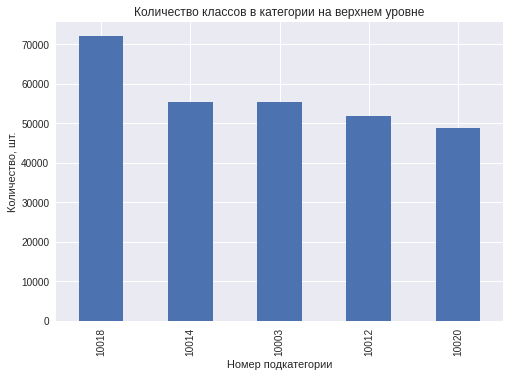

In [46]:
plt.style.use('seaborn')
train['level_2'].value_counts().plot(kind='bar')
plt.title('Количество классов в категории на верхнем уровне')
plt.xlabel('Номер подкатегории')
plt.ylabel('Количество, шт.')
plt.show()


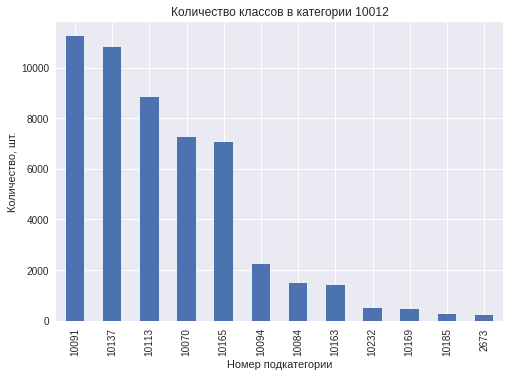

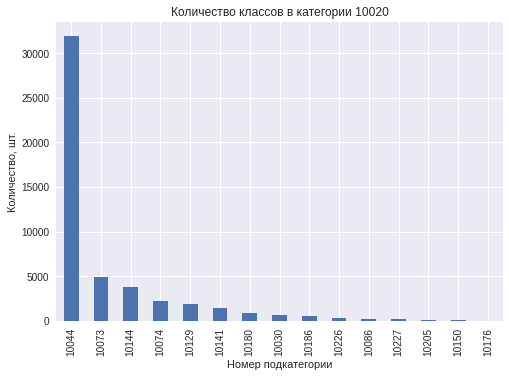

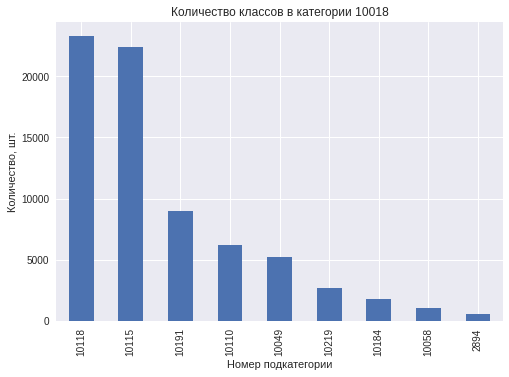

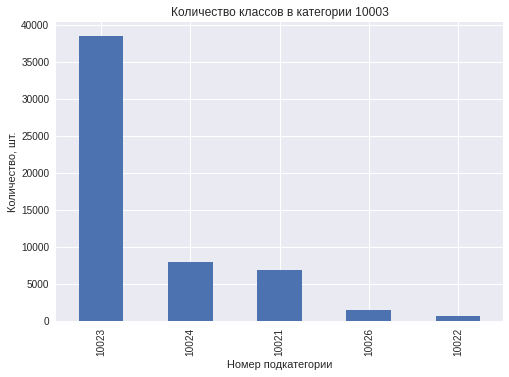

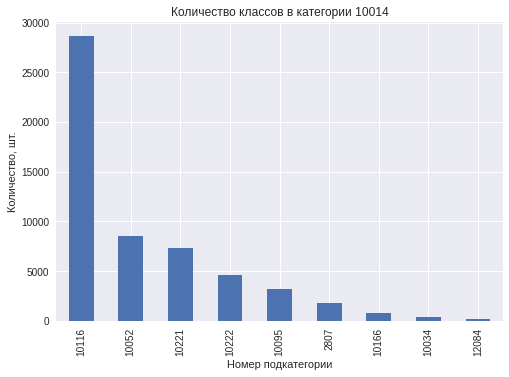

In [47]:
for cat in train['level_2'].unique():

    train.loc[train['level_2']==cat, 'level_3'].value_counts().plot(kind='bar', rot=90)
    plt.title(f'Количество классов в категории {cat}')
    plt.xlabel('Номер подкатегории')
    plt.ylabel('Количество, шт.')
    plt.show()

# **Обучение и валидация моделей**
Рассмотрим следующие модели:
 - MultinomialNB;
 - Логистическая регрессия;
 - LinearSVC;
 - RidgeClassifier;
 - DecisionTreeClassifier.

 Текстовые данные переведем в векторный вид при помощи TF-IDF, на данном этапе без n-gram.

## **Вспомогательные функции**

In [48]:
# разделение выборки на тренировочную и валидационную
# также удаляем дубликаты в тренировочной выборке
def train_valid_split(df):
  x = df['title_all']
  y = df[['level_2', 'level_3', 'level_4', 'level_5', 'level_6']]

  x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.3,
                                                        random_state=42)

  x_train.drop_duplicates(inplace=True)
  y_train = y_train.loc[x_train.index]

  y_valid.fillna('non_type', inplace=True)
  y_train.fillna('non_type', inplace=True)

  return x_train, x_valid, y_train, y_valid

In [49]:
# решено обучать классификатор для каждой родительской категории, поэтому
# данная функция будет выбирать из тренировочной и валидационной выборок
# данные для родительского класса и соответствующих подклассов и передавать их 
# в следующую функцию
# а еще внутри функция векторизует текстовые данные при помощи TF-IDF

def train_val_split(id, col, col_2, x_train, x_valid, y_train, y_valid,tf_idf):


  y_train_parent = y_train.loc[y_train[col]==id, col_2]
  x_train_parent = x_train.loc[y_train_parent.index]
  y_valid_parent = y_valid.loc[y_valid[f'{col}_preds']==id, col_2]
  x_valid_parent = x_valid.loc[y_valid_parent.index]

  if x_train_parent.shape[0]==0 or x_valid_parent.shape[0]==0:
    return x_train_parent, x_valid_parent, y_train_parent, y_valid_parent
  else:
    x_train_parent = tf_idf.transform(x_train_parent)
    x_valid_parent = tf_idf.transform(x_valid_parent)

  return x_train_parent, x_valid_parent, y_train_parent, y_valid_parent

In [50]:
# функция для обучения и классификации

def fit_predict(model, col, col_2, x_train, x_valid, y_train, y_valid,tf_idf):
  y_valid[f'{col_2}_preds'] = 'w'
  list_labels = y_train[col].unique()
  for id in tqdm(list_labels):
     x_train_parent, x_valid_parent, y_train_parent, y_valid_parent = train_val_split(id, col, col_2, x_train, x_valid, y_train, y_valid,tf_idf)
    #  print(x_train_parent.shape, x_valid_parent.shape, y_train_parent.shape, y_valid_parent.shape)
     if x_train_parent.shape[0]==0 or x_valid_parent.shape[0]==0:
       continue
     if len(y_train_parent.unique())<2:
       preds = y_train_parent.to_list()[0]
       y_valid.loc[y_valid[f'{col}_preds']==id, f'{col_2}_preds'] = preds
     else:
       model.fit(x_train_parent, y_train_parent)
       preds = model.predict(x_valid_parent)
      #  print(preds)
     
       y_valid.loc[y_valid[f'{col}_preds']==id, f'{col_2}_preds'] = preds

In [51]:
# функция для визуализации результатов на валидационной выборке на каждом уровне

def res_train(y_valid):
  cols = ['level_2', 'level_3', 'level_4', 'level_5', 'level_6']
  res = pd.DataFrame(columns=['level', 'F1'])


  # results = results.append({'Name' : 'MNB', 'Acc' : accuracy_score(valid_mnb['level_6'], valid_mnb['level_6_preds'])}, ignore_index=True)


  for col in cols:
    acc_level = f1_score(y_valid.loc[y_valid[col]!="non_type", col],y_valid.loc[y_valid[col]!="non_type", f'{col}_preds'], average='weighted')
    res = res.append({'level' : col, 'F1' : acc_level}, ignore_index=True)


  ax = sns.barplot(x='level', y='F1', data=res)
  plt.title('Результат обучения модели по уровням', pad=15, fontdict={'fontsize':15})
  plt.ylabel('F1-score на уровне', fontdict={'fontsize':13})
  plt.xlabel('Уровень', fontdict={'fontsize':13})
  for i in ax.patches:
    ax.text(i.get_xy()[0]+0.25, i.get_height()-0.1,
            (i.get_height()).round(3), fontsize=12)

In [52]:
# результаты
# на данном этапе оцениваем F1
results = pd.DataFrame(columns=['Name', 'F1'])

## **MultinomialNB**

In [53]:
x_train, x_valid, y_train, y_valid = train_valid_split(train)

In [54]:
mnb = MultinomialNB(alpha=0.4)

In [55]:
tf_idf = TfidfVectorizer()
tf_idf.fit(x_train)


TfidfVectorizer()

In [56]:
y_train_parent = y_train['level_2']
x_train_parent = tf_idf.transform(x_train)
y_valid_parent = y_valid['level_2']
x_valid_parent = tf_idf.transform(x_valid)

mnb.fit(x_train_parent,y_train_parent)
preds = mnb.predict(x_valid_parent)
y_valid['level_2_preds'] = preds

In [57]:
fit_predict(mnb, 'level_2', 'level_3', x_train, x_valid, y_train, y_valid,tf_idf)


100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


In [58]:
fit_predict(mnb, 'level_3', 'level_4', x_train, x_valid, y_train, y_valid,tf_idf)


100%|██████████| 50/50 [00:08<00:00,  5.78it/s]


In [59]:
fit_predict(mnb, 'level_4', 'level_5', x_train, x_valid, y_train, y_valid,tf_idf)


100%|██████████| 386/386 [00:26<00:00, 14.45it/s]


In [60]:
fit_predict(mnb, 'level_5', 'level_6', x_train, x_valid, y_train, y_valid,tf_idf)

100%|██████████| 981/981 [00:43<00:00, 22.75it/s]


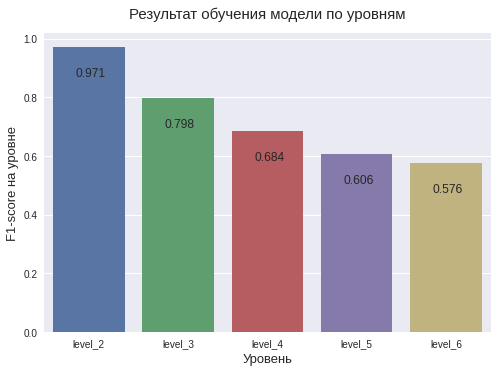

In [61]:
res_train(y_valid)

In [62]:
# здесь расположим листовые категории на одном уровне для расчета F1

y_valid.loc[y_valid.level_4_preds=='non_type','level_4_preds'] = y_valid.level_3_preds
y_valid.loc[y_valid.level_5_preds=='non_type','level_5_preds'] = y_valid.level_4_preds
y_valid.loc[y_valid.level_6_preds=='non_type','level_6_preds'] = y_valid.level_5_preds

y_valid.loc[y_valid.level_4=='non_type','level_4'] = y_valid.level_3
y_valid.loc[y_valid.level_5=='non_type','level_5'] = y_valid.level_4
y_valid.loc[y_valid.level_6=='non_type','level_6'] = y_valid.level_5


In [63]:
valid_mnb = y_valid.copy()

In [64]:
results = results.append({'Name' : 'MNB', 'F1' : f1_score(valid_mnb['level_6'], valid_mnb['level_6_preds'], average='weighted')}, ignore_index=True)
results

,Name,F1
0,MNB,0.576293


# **Лог рег**

In [65]:
x_train, x_valid, y_train, y_valid = train_valid_split(train)

In [66]:
model_lr = LogisticRegression(random_state=1,
                              max_iter=500,
                              multi_class = 'multinomial'
                              )

In [67]:
y_train_parent = y_train['level_2']
x_train_parent = tf_idf.transform(x_train)
y_valid_parent = y_valid['level_2']
x_valid_parent = tf_idf.transform(x_valid)

model_lr.fit(x_train_parent,y_train_parent)
preds = model_lr.predict(x_valid_parent)
y_valid['level_2_preds'] = preds


In [68]:
fit_predict(model_lr, 'level_2', 'level_3', x_train, x_valid, y_train, y_valid, tf_idf)

100%|██████████| 5/5 [03:07<00:00, 37.49s/it]


In [69]:
fit_predict(model_lr, 'level_3', 'level_4', x_train, x_valid, y_train, y_valid, tf_idf)

100%|██████████| 50/50 [06:14<00:00,  7.50s/it]


In [70]:
fit_predict(model_lr, 'level_4', 'level_5', x_train, x_valid, y_train, y_valid, tf_idf)

100%|██████████| 386/386 [09:22<00:00,  1.46s/it]


In [71]:
fit_predict(model_lr, 'level_5', 'level_6', x_train, x_valid, y_train, y_valid, tf_idf)

100%|██████████| 981/981 [01:16<00:00, 12.81it/s]


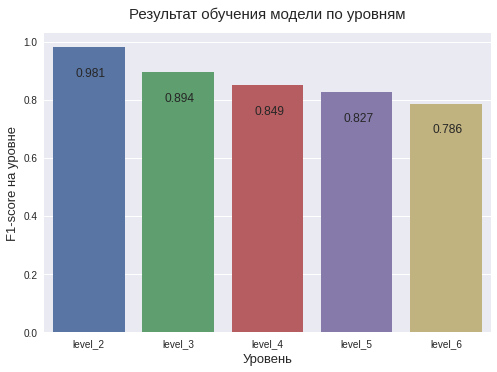

In [72]:
res_train(y_valid)

In [73]:
# здесь расположим листовые категории на одном уровне для расчета F1

y_valid.loc[y_valid.level_4_preds=='non_type','level_4_preds'] = y_valid.level_3_preds
y_valid.loc[y_valid.level_5_preds=='non_type','level_5_preds'] = y_valid.level_4_preds
y_valid.loc[y_valid.level_6_preds=='non_type','level_6_preds'] = y_valid.level_5_preds


y_valid.loc[y_valid.level_4=='non_type','level_4'] = y_valid.level_3
y_valid.loc[y_valid.level_5=='non_type','level_5'] = y_valid.level_4
y_valid.loc[y_valid.level_6=='non_type','level_6'] = y_valid.level_5

In [74]:
valid_lr = y_valid.copy()

In [75]:
results = results.append({'Name' : 'Log_reg', 'F1' : f1_score(valid_lr['level_6'], valid_lr['level_6_preds'], average='weighted')}, ignore_index=True)
results

,Name,F1
0,MNB,0.576293
1,Log_reg,0.806613


# **LinearSVC**

In [76]:
x_train, x_valid, y_train, y_valid = train_valid_split(train)

In [77]:
clf = LinearSVC()


y_train_parent = y_train['level_2']
x_train_parent = tf_idf.transform(x_train)
y_valid_parent = y_valid['level_2']
x_valid_parent = tf_idf.transform(x_valid)

clf.fit(x_train_parent,y_train_parent)
preds = clf.predict(x_valid_parent)
y_valid['level_2_preds'] = preds

In [78]:

fit_predict(clf, 'level_2', 'level_3', x_train, x_valid, y_train, y_valid, tf_idf)

100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


In [79]:
fit_predict(clf, 'level_3', 'level_4', x_train, x_valid, y_train, y_valid, tf_idf)

100%|██████████| 50/50 [00:10<00:00,  4.97it/s]


In [80]:
fit_predict(clf, 'level_4', 'level_5', x_train, x_valid, y_train, y_valid, tf_idf)

100%|██████████| 386/386 [00:27<00:00, 14.25it/s]


In [81]:
fit_predict(clf, 'level_5', 'level_6', x_train, x_valid, y_train, y_valid, tf_idf)

100%|██████████| 981/981 [00:51<00:00, 19.09it/s]


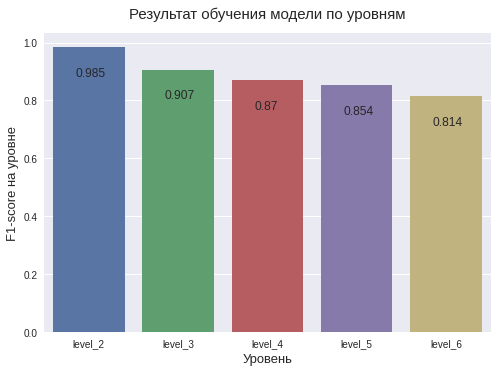

In [82]:
res_train(y_valid)

In [83]:
# здесь расположим листовые категории на одном уровне для расчета F1
y_valid.loc[y_valid.level_4_preds=='non_type','level_4_preds'] = y_valid.level_3_preds
y_valid.loc[y_valid.level_5_preds=='non_type','level_5_preds'] = y_valid.level_4_preds
y_valid.loc[y_valid.level_6_preds=='non_type','level_6_preds'] = y_valid.level_5_preds


y_valid.loc[y_valid.level_4=='non_type','level_4'] = y_valid.level_3
y_valid.loc[y_valid.level_5=='non_type','level_5'] = y_valid.level_4
y_valid.loc[y_valid.level_6=='non_type','level_6'] = y_valid.level_5

In [84]:
valid_lsvc = y_valid.copy()

In [85]:
results = results.append({'Name' : 'LinearSVC', 'F1' : f1_score(valid_lsvc['level_6'], valid_lsvc['level_6_preds'], average='weighted')}, ignore_index=True)
results

,Name,F1
0,MNB,0.576293
1,Log_reg,0.806613
2,LinearSVC,0.837763


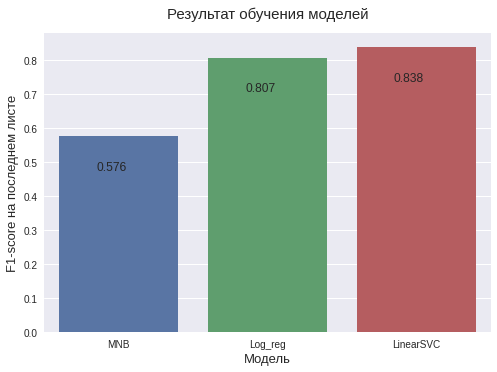

In [86]:

ax = sns.barplot(x='Name', y='F1', data=results)
plt.title('Результат обучения моделей', pad=15, fontdict={'fontsize':15})
plt.ylabel('F1-score на последнем листе', fontdict={'fontsize':13})
plt.xlabel('Модель', fontdict={'fontsize':13})
for i in ax.patches:
  ax.text(i.get_xy()[0]+0.25, i.get_height()-0.1,
          (i.get_height()).round(3), fontsize=12)
  


# **RidgeClassifier**

In [87]:
x_train, x_valid, y_train, y_valid = train_valid_split(train)

In [88]:
r_clf = RidgeClassifier()

In [89]:
y_train_parent = y_train['level_2']
x_train_parent = tf_idf.transform(x_train)
y_valid_parent = y_valid['level_2']
x_valid_parent = tf_idf.transform(x_valid)

r_clf.fit(x_train_parent,y_train_parent)
preds = r_clf.predict(x_valid_parent)
y_valid['level_2_preds'] = preds


In [90]:
fit_predict(r_clf, 'level_2', 'level_3', x_train, x_valid, y_train, y_valid, tf_idf)

100%|██████████| 5/5 [00:25<00:00,  5.07s/it]


In [91]:
fit_predict(r_clf, 'level_3', 'level_4', x_train, x_valid, y_train, y_valid, tf_idf)

100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


In [92]:
fit_predict(r_clf, 'level_4', 'level_5', x_train, x_valid, y_train, y_valid, tf_idf)

100%|██████████| 386/386 [00:53<00:00,  7.20it/s]


In [93]:
fit_predict(r_clf, 'level_5', 'level_6', x_train, x_valid, y_train, y_valid, tf_idf)

100%|██████████| 981/981 [00:56<00:00, 17.29it/s]


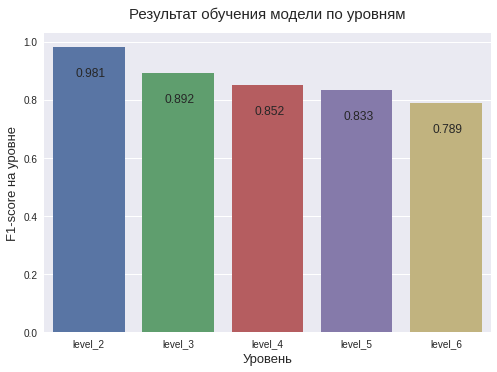

In [94]:
res_train(y_valid)

In [95]:
# здесь расположим листовые категории на одном уровне для расчета F1
y_valid.loc[y_valid.level_4_preds=='non_type','level_4_preds'] = y_valid.level_3_preds
y_valid.loc[y_valid.level_5_preds=='non_type','level_5_preds'] = y_valid.level_4_preds
y_valid.loc[y_valid.level_6_preds=='non_type','level_6_preds'] = y_valid.level_5_preds


y_valid.loc[y_valid.level_4=='non_type','level_4'] = y_valid.level_3
y_valid.loc[y_valid.level_5=='non_type','level_5'] = y_valid.level_4
y_valid.loc[y_valid.level_6=='non_type','level_6'] = y_valid.level_5

In [96]:
valid_rclf = y_valid.copy()

In [97]:
results = results.append({'Name' : 'RidgeClassifier', 'F1' : f1_score(valid_rclf['level_6'], valid_rclf['level_6_preds'], average='weighted')}, ignore_index=True)
results

,Name,F1
0,MNB,0.576293
1,Log_reg,0.806613
2,LinearSVC,0.837763
3,RidgeClassifier,0.815001


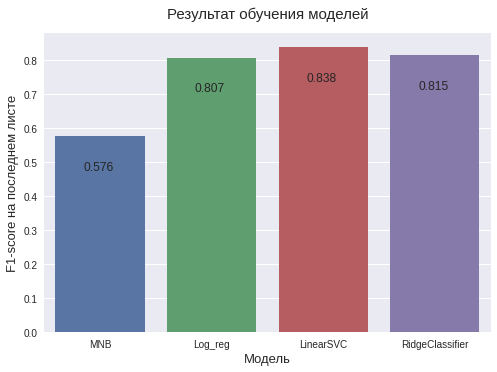

In [98]:

ax = sns.barplot(x='Name', y='F1', data=results)
plt.title('Результат обучения моделей', pad=15, fontdict={'fontsize':15})
plt.ylabel('F1-score на последнем листе', fontdict={'fontsize':13})
plt.xlabel('Модель', fontdict={'fontsize':13})
for i in ax.patches:
  ax.text(i.get_xy()[0]+0.25, i.get_height()-0.1,
          (i.get_height()).round(3), fontsize=12)

Кросс-валидация

In [99]:
# from sklearn.model_selection import KFold

# clf = LinearSVC(dual=False)

# kf = KFold(n_splits=5, shuffle=True, random_state=12)
# tf_idf = TfidfVectorizer()
#     # ngram_range=(1,2)
# f_scores = []
# for train_idx, val_idx in kf.split(train):
#     # векторизация

#     x_train = train.iloc[train_idx]['title_all']
#     x_valid = train.iloc[val_idx]['title_all']

#     y_train = train.iloc[train_idx]
#     y_valid = train.iloc[val_idx]

#     x_train_1 = tf_idf.fit_transform(x_train)
#     x_valid_1 = tf_idf.transform(x_valid)

    

#     clf.fit(x_train_1,y_train['level_2'])
#     preds = clf.predict(x_valid_1)
#     y_valid['level_2_preds'] = preds

#     fit_predict(clf, 'level_2', 'level_3', x_train, x_valid, y_train, y_valid, tf_idf)
#     fit_predict(clf, 'level_3', 'level_4', x_train, x_valid, y_train, y_valid, tf_idf)
#     fit_predict(clf, 'level_4', 'level_5', x_train, x_valid, y_train, y_valid, tf_idf)
#     fit_predict(clf, 'level_5', 'level_6', x_train, x_valid, y_train, y_valid, tf_idf)

#     y_valid.loc[y_valid.level_4_preds=='non_type','level_4_preds'] = y_valid.level_3_preds
#     y_valid.loc[y_valid.level_5_preds=='non_type','level_5_preds'] = y_valid.level_4_preds
#     y_valid.loc[y_valid.level_6_preds=='non_type','level_6_preds'] = y_valid.level_5_preds


#     y_valid.loc[y_valid.level_4=='non_type','level_4'] = y_valid.level_3
#     y_valid.loc[y_valid.level_5=='non_type','level_5'] = y_valid.level_4
#     y_valid.loc[y_valid.level_6=='non_type','level_6'] = y_valid.level_5
    
    
    
    
#     f1 = f1_score(y_valid['level_6'], y_valid['level_6_preds'], average='weighted')





#     f_scores.append(f1)

# f_scores

## **DecisionTreeClassifier**

In [100]:
tree_clf = DecisionTreeClassifier(random_state=0)

In [101]:
x_train, x_valid, y_train, y_valid = train_valid_split(train)

In [102]:
y_train_parent = y_train['level_2']
x_train_parent = tf_idf.transform(x_train)
y_valid_parent = y_valid['level_2']
x_valid_parent = tf_idf.transform(x_valid)

tree_clf.fit(x_train_parent,y_train_parent)
preds = tree_clf.predict(x_valid_parent)
y_valid['level_2_preds'] = preds

In [103]:
fit_predict(tree_clf, 'level_2', 'level_3', x_train, x_valid, y_train, y_valid, tf_idf)

100%|██████████| 5/5 [00:50<00:00, 10.03s/it]


In [104]:
fit_predict(tree_clf, 'level_3', 'level_4', x_train, x_valid, y_train, y_valid, tf_idf)

100%|██████████| 50/50 [00:31<00:00,  1.59it/s]


In [105]:
fit_predict(tree_clf, 'level_4', 'level_5', x_train, x_valid, y_train, y_valid, tf_idf)

100%|██████████| 386/386 [00:39<00:00,  9.77it/s]


In [106]:
fit_predict(tree_clf, 'level_5', 'level_6', x_train, x_valid, y_train, y_valid, tf_idf)

100%|██████████| 981/981 [00:52<00:00, 18.64it/s]


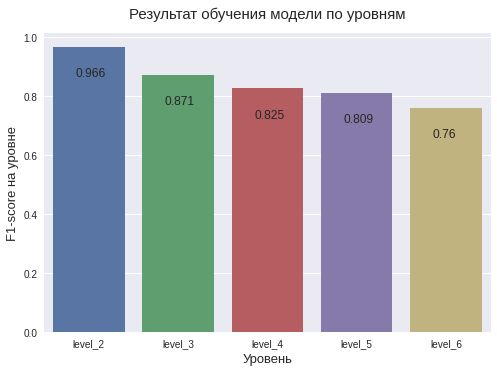

In [107]:
res_train(y_valid)

In [108]:
y_valid.loc[y_valid.level_4_preds=='non_type','level_4_preds'] = y_valid.level_3_preds
y_valid.loc[y_valid.level_5_preds=='non_type','level_5_preds'] = y_valid.level_4_preds
y_valid.loc[y_valid.level_6_preds=='non_type','level_6_preds'] = y_valid.level_5_preds

y_valid.loc[y_valid.level_4=='non_type','level_4'] = y_valid.level_3
y_valid.loc[y_valid.level_5=='non_type','level_5'] = y_valid.level_4
y_valid.loc[y_valid.level_6=='non_type','level_6'] = y_valid.level_5

In [109]:
valid_dt = y_valid.copy()

In [110]:
results = results.append({'Name' : 'DecisionTreeClassifier', 'F1' : f1_score(valid_dt['level_6'], valid_dt['level_6_preds'], average='weighted')}, ignore_index=True)
results

,Name,F1
0,MNB,0.576293
1,Log_reg,0.806613
2,LinearSVC,0.837763
3,RidgeClassifier,0.815001
4,DecisionTreeClassifier,0.789956


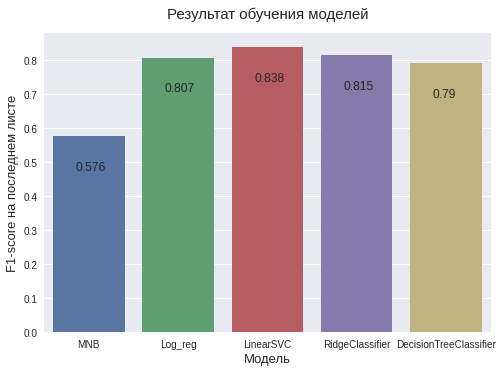

In [111]:
ax = sns.barplot(x='Name', y='F1', data=results)
plt.title('Результат обучения моделей', pad=15, fontdict={'fontsize':15})
plt.ylabel('F1-score на последнем листе', fontdict={'fontsize':13})
plt.xlabel('Модель', fontdict={'fontsize':13})
for i in ax.patches:
  ax.text(i.get_xy()[0]+0.25, i.get_height()-0.1,
          (i.get_height()).round(3), fontsize=12)

## **Подберем ngram_range**

Лучший результат показала модель LinearSVC, для нее и подберем ngram_range

In [112]:
tf_idf = TfidfVectorizer(ngram_range=(1,2))
tf_idf.fit(x_train)


TfidfVectorizer(ngram_range=(1, 2))

In [113]:
x_train, x_valid, y_train, y_valid = train_valid_split(train)

In [114]:
clf = LinearSVC()


y_train_parent = y_train['level_2']
x_train_parent = tf_idf.transform(x_train)
y_valid_parent = y_valid['level_2']
x_valid_parent = tf_idf.transform(x_valid)

clf.fit(x_train_parent,y_train_parent)
preds = clf.predict(x_valid_parent)
y_valid['level_2_preds'] = preds

In [115]:
fit_predict(clf, 'level_2', 'level_3', x_train, x_valid, y_train, y_valid, tf_idf)

100%|██████████| 5/5 [00:14<00:00,  2.90s/it]


In [116]:
fit_predict(clf, 'level_3', 'level_4', x_train, x_valid, y_train, y_valid, tf_idf)

100%|██████████| 50/50 [00:20<00:00,  2.48it/s]


In [117]:
fit_predict(clf, 'level_4', 'level_5', x_train, x_valid, y_train, y_valid, tf_idf)

100%|██████████| 386/386 [00:44<00:00,  8.67it/s]


In [118]:
fit_predict(clf, 'level_5', 'level_6', x_train, x_valid, y_train, y_valid, tf_idf)

100%|██████████| 981/981 [01:08<00:00, 14.27it/s]


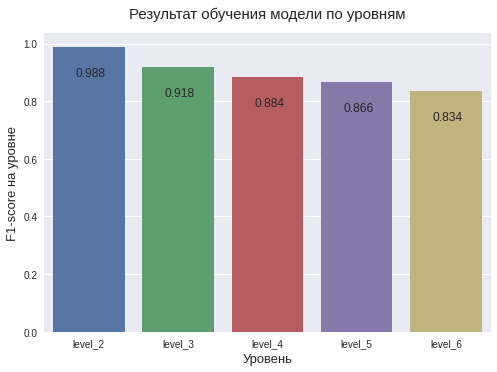

In [119]:
res_train(y_valid)

In [120]:
valid_lsvc = y_valid.copy()

In [121]:
y_valid.loc[y_valid.level_4_preds=='non_type','level_4_preds'] = y_valid.level_3_preds
y_valid.loc[y_valid.level_5_preds=='non_type','level_5_preds'] = y_valid.level_4_preds
y_valid.loc[y_valid.level_6_preds=='non_type','level_6_preds'] = y_valid.level_5_preds

y_valid.loc[y_valid.level_4=='non_type','level_4'] = y_valid.level_3
y_valid.loc[y_valid.level_5=='non_type','level_5'] = y_valid.level_4
y_valid.loc[y_valid.level_6=='non_type','level_6'] = y_valid.level_5

In [122]:
results = results.append({'Name' : 'LinearSVC_ngram_1_2', 'F1' : f1_score(y_valid['level_6'], y_valid['level_6_preds'], average='weighted')}, ignore_index=True)
results

,Name,F1
0,MNB,0.576293
1,Log_reg,0.806613
2,LinearSVC,0.837763
3,RidgeClassifier,0.815001
4,DecisionTreeClassifier,0.789956
5,LinearSVC_ngram_1_2,0.852554


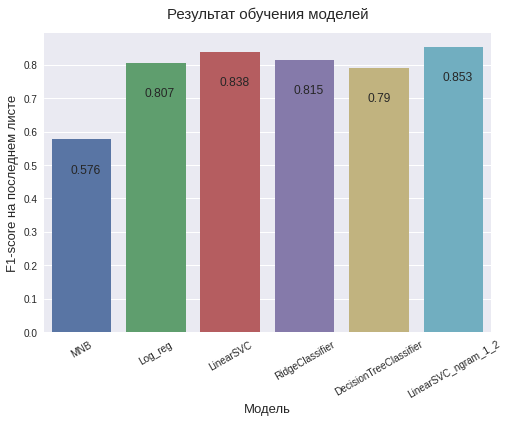

In [123]:
ax = sns.barplot(x='Name', y='F1', data=results)
plt.title('Результат обучения моделей', pad=15, fontdict={'fontsize':15})
plt.ylabel('F1-score на последнем листе', fontdict={'fontsize':13})
plt.xlabel('Модель', fontdict={'fontsize':13})
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
for i in ax.patches:
  ax.text(i.get_xy()[0]+0.25, i.get_height()-0.1,
          (i.get_height()).round(3), fontsize=12)

### **Вывод**
Лучший результат при ngram_range=(1,2)

## **Расчет hF**
Здесь рассчитаем иерархический F1. Рассчитаем три версии:
 - невзвешенный;
 - взвешенный на этапе расчета F1;
 - взвешенный на этапе расчета precision-recall.

In [124]:

# функция возвращает списки значений для расчета hF
def hierarchical_f1(id, y_valid):

  list_cols = ['level_2', 'level_3', 'level_4', 'level_5', 'level_6']
  for i in list_cols:
    if y_valid[i].isin([id]).any():
      n = list_cols.index(i) + 1
      break

  list_cols_preds = [f'{x}_preds' for x in list_cols[:n]]
  true_path = y_valid[y_valid[f'level_{n+1}']==id].iloc[0][:n].to_list()


  t = (y_valid[list_cols[:n]]==true_path).sum(axis=1).sum()
  p = (y_valid[list_cols_preds[:n]]==true_path).sum(axis=1).sum()

  a = (y_valid[list_cols[:n]]==true_path)
  b = (y_valid[list_cols_preds[:n]]==true_path)
  pxt = ((np.array(a)==True) & (np.array(b)==True)).sum(axis=1).sum()
  count_id = y_valid[f'level_{n+1}'].value_counts()[id]
 
  return p, t, pxt, count_id

In [125]:
%%time
list_p = []
list_t = []
list_pxt = []
list_count = []
for i in y_valid['level_6'].unique():
    p,t, pxt, count_id = hierarchical_f1(i, valid_lsvc)
    list_p.append(p)
    list_t.append(t)
    list_pxt.append(pxt)
    list_count.append(count_id)


CPU times: user 5min 34s, sys: 2.08 s, total: 5min 36s
Wall time: 5min 35s


In [126]:
f1_res = pd.DataFrame(columns=['Name', 'Value'])

In [127]:
# невзвешенный F1
hpxt = sum(list_pxt)
hp = sum(list_p)
ht = sum(list_t)

hP = hpxt/hp
hR = hpxt/ht

hF = 2*hR*hP/(hR+hP)

f1_res = f1_res.append({'Name' : 'hF невзвешенный', 'Value' : hF}, ignore_index=True)


In [128]:
# взвешенный на этапе расчета F1

sum_f1 = []
for i, val in enumerate(list_pxt):
  pp = val/list_p[i]
  rr = val/list_t[i]

  ff = list_count[i]*2*pp*rr/(pp+rr)

  sum_f1.append(ff)

hF = sum(sum_f1)/sum(list_count)
f1_res = f1_res.append({'Name' : 'hF взвешенный (F1)', 'Value' : hF}, ignore_index=True)

In [129]:
# взвешенный на этапе расчета precision-recall

sum_pp = []
sum_rr = []
for i, val in enumerate(list_pxt):
  pp = list_count[i]*val/list_p[i]
  rr = list_count[i]*val/list_t[i]
  sum_pp.append(pp)
  sum_rr.append(rr)

pp = sum(sum_pp)/sum(list_count)
rr = sum(sum_rr)/sum(list_count)
hF = 2*pp*rr/(pp+rr)


f1_res = f1_res.append({'Name' : 'hF взвешенный (precision-recall)', 'Value' : hF}, ignore_index=True)

In [130]:
f1_res

,Name,Value
0,hF невзвешенный,0.974483
1,hF взвешенный (F1),0.972659
2,hF взвешенный (precision-recall),0.972696


# Классификация тестовой выборки

## Подготовка данных

In [131]:
df_test.head()

,id,title,short_description,name_value_characteristics,rating,feedback_quantity
0,1070974,Браслет из натуральных камней LOTUS,None,None,0.000000,0
1,450413,Fusion Life - Шампунь для сухих и окрашенных в...,None,None,4.333333,6
2,126857,"Микрофон для ПК jack 3,5мм всенаправленный","универсальный 3,5 мм микрофон запишет ваш звук",None,3.708333,24
3,1577569,Серьги гвоздики сердце,Серьги гвоздики сердце,None,0.000000,0
4,869328,"Чёрно-красная стильная брошь ""Тюльпаны"" из акр...",Стильная и яркая брошь ручной работы! Великоле...,None,0.000000,0


In [132]:
df_test.name_value_characteristics = df_test.name_value_characteristics.fillna('ноль')
df_test.short_description = df_test.short_description.fillna('ноль')
df_test.short_description = df_test.short_description.replace('None','ноль')

df_test = to_lemma(df_test, 'title')
df_test = to_lemma(df_test, 'short_description')
df_test = to_lemma(df_test, 'name_value_characteristics')

df_test['title_all'] = df_test['title'] +	df_test['short_description'] + df_test['name_value_characteristics']
df_test['title_all'] = df_test['title_all'].apply(lambda x: x.replace('ноль', ''))
df_test.head()

,id,title,short_description,name_value_characteristics,rating,feedback_quantity,title_all
0,1070974,браслет натуральный камень lotus,ноль,ноль,0.000000,0,браслет натуральный камень lotus
1,450413,fusion life шампунь сухой окрашивать волос ли...,ноль,ноль,4.333333,6,fusion life шампунь сухой окрашивать волос ли...
2,126857,микрофон пк jack 3 5мм всенаправленный,универсальный 3 5 мм микрофон записывать ваш ...,ноль,3.708333,24,микрофон пк jack 3 5мм всенаправленный униве...
3,1577569,серьга гвоздика сердце,серьга гвоздика сердце,ноль,0.000000,0,серьга гвоздика сердце серьга гвоздика сердц...
4,869328,черный красный стильный брошь тюльпан акрил б...,стильный яркий брошь ручной работа великолепн...,ноль,0.000000,0,черный красный стильный брошь тюльпан акрил б...


In [133]:
result = df_test[['id']]
result.set_index('id', inplace=True)

In [134]:
df_test.set_index('id', inplace=True)

In [135]:
test = df_test['title_all']
test.head()

id
1070974                  браслет натуральный камень lotus   
450413      fusion life шампунь сухой окрашивать волос ли...
126857      микрофон пк jack 3 5мм всенаправленный  униве...
1577569     серьга гвоздика сердце  серьга гвоздика сердц...
869328      черный красный стильный брошь тюльпан акрил б...
Name: title_all, dtype: object

## **Классификация**

In [136]:
pd.options.mode.chained_assignment = None

In [137]:
# тут немного переделали функции

def train_val_split(id, col, col_2, x_train, x_valid, y_train, y_valid,tf_idf):


  y_train_parent = y_train.loc[y_train[col]==id, col_2]
  x_train_parent = x_train.loc[y_train_parent.index]
  y_valid_parent = y_valid.loc[y_valid[f'{col}_preds']==id,f'{col}_preds']
  x_valid_parent = x_valid.loc[y_valid_parent.index]

  if x_train_parent.shape[0]==0 or x_valid_parent.shape[0]==0:
    return x_train_parent, x_valid_parent, y_train_parent, y_valid_parent
  else:
    x_train_parent = tf_idf.transform(x_train_parent)
    x_valid_parent = tf_idf.transform(x_valid_parent)

  return x_train_parent, x_valid_parent, y_train_parent, y_valid_parent


# функция для обучения и классификации

def fit_predict(model, col, col_2, x_train, x_valid, y_train, y_valid,tf_idf):
  y_valid[f'{col_2}_preds'] = 'w'
  list_labels = y_train[col].unique()
  for id in tqdm(list_labels):
     x_train_parent, x_valid_parent, y_train_parent, y_valid_parent = train_val_split(id, col, col_2, x_train, x_valid, y_train, y_valid,tf_idf)
   
     if x_train_parent.shape[0]==0 or x_valid_parent.shape[0]==0:
       continue
     if len(y_train_parent.unique())<2:
       preds = y_train_parent.to_list()[0]
       y_valid.loc[y_valid[f'{col}_preds']==id, f'{col_2}_preds'] = preds
     else:
       model.fit(x_train_parent, y_train_parent)
       preds = model.predict(x_valid_parent)
      #  print(preds)
     
       y_valid.loc[y_valid[f'{col}_preds']==id, f'{col_2}_preds'] = preds


In [138]:
train.drop_duplicates(inplace=True)

In [139]:
x_train = train['title_all']
y_train = train[['level_2', 'level_3', 'level_4', 'level_5', 'level_6']]

In [140]:
tf_idf = TfidfVectorizer(ngram_range=(1,2))
tf_idf.fit(x_train)

TfidfVectorizer(ngram_range=(1, 2))

In [141]:
clf = LinearSVC()

In [142]:
y_train_parent = y_train['level_2']
x_train_parent = tf_idf.transform(x_train)

test_parent = tf_idf.transform(test)

clf.fit(x_train_parent,y_train_parent)
preds = clf.predict(test_parent)
result['level_2_preds'] = preds

In [143]:
fit_predict(clf, 'level_2', 'level_3', x_train, test, y_train, result, tf_idf)


100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


In [144]:
fit_predict(clf, 'level_3', 'level_4', x_train, test, y_train, result, tf_idf)

100%|██████████| 50/50 [00:24<00:00,  2.05it/s]


In [145]:
fit_predict(clf, 'level_4', 'level_5', x_train, test, y_train, result, tf_idf)

100%|██████████| 386/386 [00:43<00:00,  8.78it/s]


In [146]:
fit_predict(clf, 'level_5', 'level_6', x_train, test, y_train, result, tf_idf)

100%|██████████| 983/983 [00:58<00:00, 16.88it/s]


## **Итоговый файл**

In [147]:
result.loc[result.level_4_preds=='non_type','level_4_preds'] = result.level_3_preds
result.loc[result.level_5_preds=='non_type','level_5_preds'] = result.level_4_preds
result.loc[result.level_6_preds=='non_type','level_6_preds'] = result.level_5_preds


In [148]:
result_end = result[['level_6_preds']]
result_end = result_end.rename_axis('id').reset_index()
result_end.rename(columns={'level_6_preds': 'predicted_category_id'}, inplace=True)
result_end['predicted_category_id'] = result_end['predicted_category_id'].astype('int')

result_end.head()

,id,predicted_category_id
0,1070974,11574
1,450413,11878
2,126857,13299
3,1577569,13061
4,869328,12813


In [150]:
result_end.to_parquet('result.parquet')